In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Load dataset
data = pd.read_csv("ecommerce_clickstream_transactions_enhanced.csv")

# Step 2: Combine Date and Timestamp into FullTimestamp
def clean_full_timestamp(row):
    try:
        date_str = f"{int(row['Year'])}-{int(row['Month']):02d}-{int(row['Day']):02d}"
        time_str = "00:" + str(row['Timestamp'])  # Make HH:MM:SS
        return pd.to_datetime(f"{date_str} {time_str}", errors='coerce')
    except:
        return pd.NaT

data['FullTimestamp'] = data.apply(clean_full_timestamp, axis=1)
data = data.dropna(subset=['FullTimestamp'])

# Step 3: Sort and compute time differences
data = data.sort_values(by=['UserID', 'FullTimestamp']).reset_index(drop=True)
data['TimeDiff_Seconds'] = data.groupby('UserID')['FullTimestamp'].diff().dt.total_seconds().fillna(0)
data['TimeDiff_Hours'] = data['TimeDiff_Seconds'] / 3600

# Step 4: Identify sessions
data['NewSession'] = (data['TimeDiff_Seconds'] > 1800).astype(int)
data['SessionID'] = data.groupby('UserID')['NewSession'].cumsum()

# Step 5: Calculate Session Duration
session_info = data.groupby(['UserID', 'SessionID'])['FullTimestamp'].agg(['min', 'max']).reset_index()
session_info['SessionDuration'] = (session_info['max'] - session_info['min']).dt.total_seconds()
data = data.merge(session_info[['UserID', 'SessionID', 'SessionDuration']], on=['UserID', 'SessionID'], how='left')

# Step 6: Ensure FullTimestamp is datetime
data['FullTimestamp'] = pd.to_datetime(data['FullTimestamp'], errors='coerce', utc=True)


# Step 7: Extract time features
data['Weekday'] = data['FullTimestamp'].dt.dayofweek
data['HourOfDay'] = data['FullTimestamp'].dt.hour

# Step 8: Encode target variable
data['Made_Purchase'] = np.where(data['EventType'] == 'purchase', 1, 0)


# Step 10: Scale numerical features
features_to_scale = [
    'SessionDuration', 'TimeDiff_Seconds', 'HourOfDay', 'Weekday',
    'ProductCount', 'EventCount', 'DaysSinceLastPurchase',
    'recency', 'frequency', 'monetary'
]
for col in features_to_scale:
    if col not in data.columns:
        data[col] = 0

scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# Step 11: Drop intermediate helper column
data.drop(columns=['NewSession'], inplace=True)

# Step 12: Save final preprocessed data
data.to_csv("final_preprocessed_data.csv", index=False)
print("✅ Preprocessing complete. Final dataset saved as 'final_preprocessed_data.csv'")
print("Final shape:", data.shape)
print("📊 Final Preprocessing Check")

# 1. Show dataset shape
print(f"\n✅ Dataset shape: {data.shape}")

# 2. List columns
print(f"\n📋 Columns: {list(data.columns)}")

# 3. Check for missing values
print("\n🔍 Missing values:")
print(data.isnull().sum()[data.isnull().sum() > 0])

# 4. Check datatypes
print("\n🧠 Data types:")
print(data.dtypes)

# 5. Quick sample of processed data
print("\n🔎 Sample rows:")
print(data.head(3))



✅ Preprocessing complete. Final dataset saved as 'final_preprocessed_data.csv'
Final shape: (58816, 27)
📊 Final Preprocessing Check

✅ Dataset shape: (58816, 27)

📋 Columns: ['UserID', 'Timestamp', 'Year', 'Month', 'Day', 'Hour', 'EventType', 'ProductID', 'Amount', 'Outcome', 'ProductCount', 'EventCount', 'DaysSinceLastPurchase', 'OneEventBeforePurchase', 'TwoEventBeforePurchase', 'ThreeEventBeforePurchase', 'FullTimestamp', 'TimeDiff_Seconds', 'TimeDiff_Hours', 'SessionID', 'SessionDuration', 'Weekday', 'HourOfDay', 'Made_Purchase', 'recency', 'frequency', 'monetary']

🔍 Missing values:
Series([], dtype: int64)

🧠 Data types:
UserID                                    int64
Timestamp                                object
Year                                      int64
Month                                     int64
Day                                       int64
Hour                                      int64
EventType                                object
ProductID                    

In [5]:
import pandas as pd

# ✅ Step 1: Make sure FullTimestamp is datetime
data['FullTimestamp'] = pd.to_datetime(data['FullTimestamp'], errors='coerce')

# ✅ Step 2: Define a reference date (latest timestamp in the dataset)
reference_date = data['FullTimestamp'].max()

# ✅ Step 3: Calculate RFM for each UserID
rfm = data.groupby('UserID').agg(
    recency = ('FullTimestamp', lambda x: (reference_date - x.max()).days),
    frequency = ('SessionID', 'nunique'),
    monetary = ('Amount', 'sum')
).reset_index()

# ✅ Step 4: Merge RFM back to the main dataset
data = data.merge(rfm, on='UserID', how='left')

# ✅ Optional: Display results
print("✅ RFM Features Added")
print(data[['UserID', 'recency', 'frequency', 'monetary']].head())


✅ RFM Features Added
   UserID  recency  frequency     monetary
0       1        1         64  1636.539644
1       1        1         64  1636.539644
2       1        1         64  1636.539644
3       1        1         64  1636.539644
4       1        1         64  1636.539644


In [ ]:
data.to_csv("final_with_rfm.csv", index=False)
print("✅ File saved as 'final_with_rfm.csv'")

Silhouette Scores by Cluster Number:
2 clusters: 0.2598
3 clusters: 0.3030
4 clusters: 0.2873
5 clusters: 0.2695
6 clusters: 0.2511
7 clusters: 0.2598
8 clusters: 0.2501
9 clusters: 0.2518
10 clusters: 0.2537

Optimal number of clusters chosen: 3


C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\2882127351.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['Cluster'] = kmeans.fit_predict(rfm_pca)



Cluster Profiling (Business Insights):
         UserID  recency  frequency  monetary
Cluster                                      
0        511.38     1.54      62.14   2884.20
1        492.84     1.28      56.88   1594.79
2        495.51     8.38      57.30   2082.37


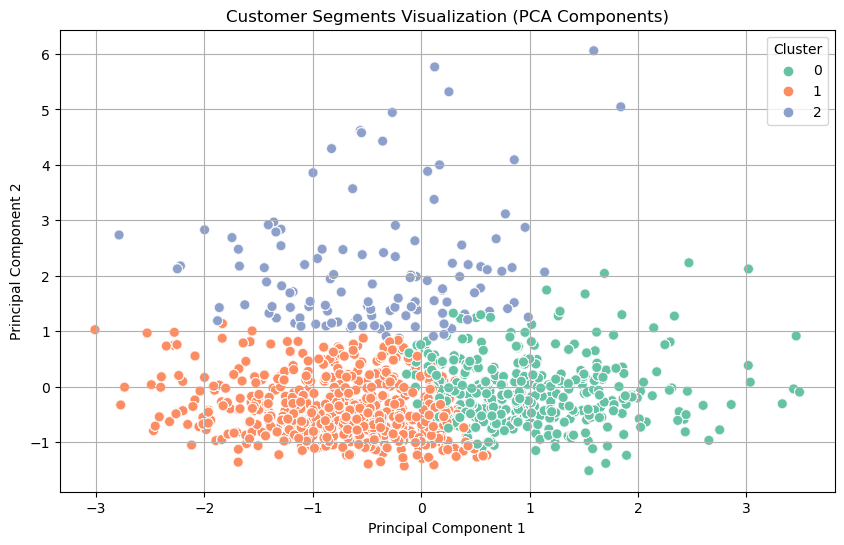

C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\2882127351.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['Marketing_Action'] = rfm_df['Cluster'].map(marketing_campaigns)


In [3]:
# Customer Segmentation Using PCA and K-Means Clustering with Business Insights

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load Data
rfm_data = pd.read_csv("final_with_rfm.csv")

# Keep only RFM relevant attributes
rfm_df = rfm_data[['UserID', 'recency', 'frequency', 'monetary']]

# Step 1: Standardize Data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])

# Step 2: PCA Analysis & Visualization
pca = PCA(n_components=3)
rfm_pca = pca.fit_transform(rfm_scaled)

# Explained variance plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Step 3: Finding Optimal k using Elbow and Silhouette Methods
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_pca, labels))

# Visualization for optimal k
fig, ax1 = plt.subplots(figsize=(10, 5))

# Elbow method plot (Inertia)
ax1.plot(k_range, inertia, marker='o', linestyle='-', color='blue')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Silhouette Score Plot
ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', color='red')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Elbow Method and Silhouette Score Analysis')
fig.tight_layout()
plt.grid(True)
plt.show()

# Print Silhouette scores explicitly
print("Silhouette Scores by Cluster Number:")
for k, score in zip(k_range, silhouette_scores):
    print(f"{k} clusters: {score:.4f}")

# Choose optimal k (highest silhouette score)
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nOptimal number of clusters chosen: {optimal_k}")

# Step 4: Perform KMeans Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_pca)

# Step 5: Business Insights - Cluster Profiling
cluster_summary = rfm_df.groupby('Cluster').mean().round(2)
print("\nCluster Profiling (Business Insights):")
print(cluster_summary)

# Visualization: PCA Cluster Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm_df['Cluster'], palette='Set2', s=50, alpha=0.7)
plt.title('Customer Segments Visualization (PCA Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Step 6: Assign Marketing Actions Based on Cluster Characteristics
marketing_campaigns = {
    0: "VIP Customers: Exclusive discounts & early sales access.",
    1: "Loyal Customers: Personalized product recommendations.",
    2: "At-Risk Customers: Win-back campaigns with incentives.",
    3: "Big Spenders: Premium upselling opportunities.",
    4: "New/Inactive Users: Engagement & onboarding initiatives."
}

rfm_df['Marketing_Action'] = rfm_df['Cluster'].map(marketing_campaigns)

# Step 7: Save clusters into separate CSV files (only relevant columns)
relevant_columns = ['UserID', 'recency', 'frequency', 'monetary', 'Cluster', 'Marketing_Action']

for cluster in rfm_df['Cluster'].unique():
    filename = f"cluster_{cluster}_customers.csv"
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster][relevant_columns]
    cluster_data.to_csv(filename, index=False)

# Final consolidated file with marketing actions
rfm_df[relevant_columns].to_csv("customer_marketing_actions.csv", index=False)

# Final cluster summary visualization (bar chart)
cluster_summary.plot(kind='bar', figsize=(12, 6))
plt.title('Average RFM values per Cluster')
plt.ylabel('Average Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(['Recency', 'Frequency', 'Monetary'], loc='upper right')
plt.show()


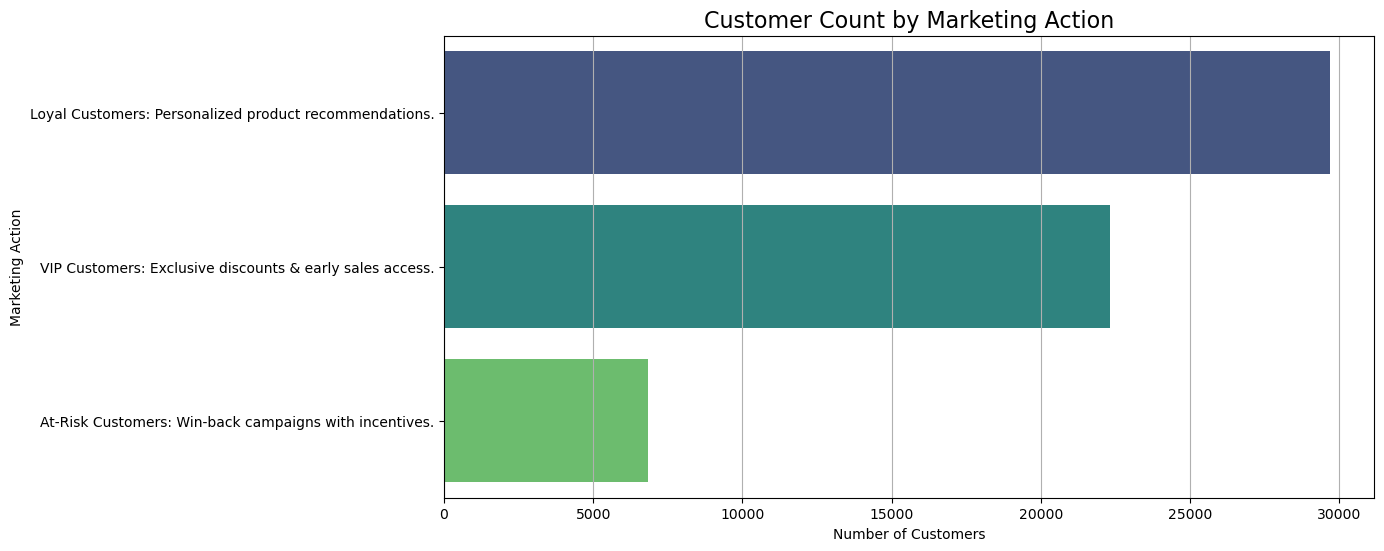

In [4]:
# Load your final dataset with clusters & marketing actions
rfm_df = pd.read_csv("customer_marketing_actions.csv")

# Count customers by marketing action
action_counts = rfm_df['Marketing_Action'].value_counts().reset_index()
action_counts.columns = ['Marketing_Action', 'Customer_Count']

# Bar plot to visualize clearly
plt.figure(figsize=(12, 6))
sns.barplot(x='Customer_Count', y='Marketing_Action', data=action_counts, palette='viridis')
plt.title("Customer Count by Marketing Action", fontsize=16)
plt.xlabel("Number of Customers")
plt.ylabel("Marketing Action")
plt.grid(axis='x')
plt.show()

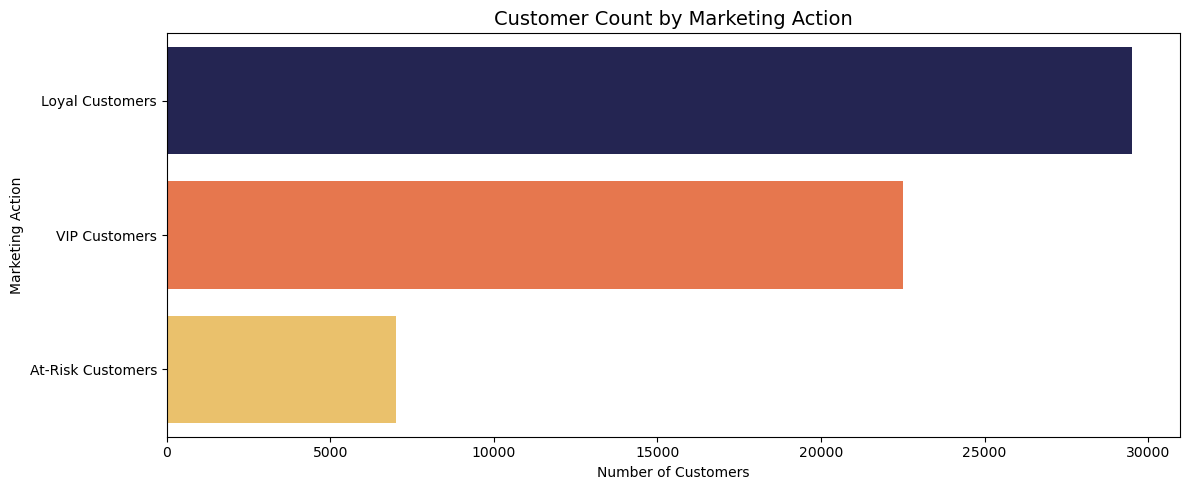

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example Data
data = {
    'Marketing Action': [
        'Loyal Customers',
        'VIP Customers',
        'At-Risk Customers'
    ],
    'Customer Count': [29500, 22500, 7000]
}

df = pd.DataFrame(data)

# Define Poster Color Palette (Navy, Orange, Yellow)
poster_colors = ['#1C1E5A', '#FF6B35', '#FFC857']  # navy, bright orange, warm yellow

# Plot
plt.figure(figsize=(12, 5))
bars = sns.barplot(
    y='Marketing Action',
    x='Customer Count',
    data=df,
    palette=poster_colors
)

plt.title("Customer Count by Marketing Action", fontsize=14)
plt.xlabel("Number of Customers")
plt.ylabel("Marketing Action")
plt.tight_layout()
plt.show()


In [8]:
# Visualize recency distribution clearly
plt.figure(figsize=(10,6))
sns.histplot(data['recency'], bins=30, kde=True)
plt.title('Distribution of Recency (days since last interaction)')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Check basic statistics for recency
print(data['recency'].describe(percentiles=[0.50, 0.75, 0.90, 0.95, 0.99]))

KeyError: 'recency'

<Figure size 1000x600 with 0 Axes>

In [9]:
rfm_data['Churn'] = rfm_data['recency'].apply(lambda x: 1 if x >= 7 else 0)

# Confirm churn distribution clearly
print(rfm_data['Churn'].value_counts())

0    54109
1     4707
Name: Churn, dtype: int64


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [11]:
rfm_data['Churn'] =rfm_data['recency'].apply(lambda x: 1 if x >= 7 else 0)

# Only relevant columns
check_columns = ['frequency', 'monetary', 'SessionDuration', 'EventCount', 'ProductCount', 'Churn']
plt.figure(figsize=(10,6))
sns.heatmap(rfm_data[check_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap clearly showing relationships")
plt.show()

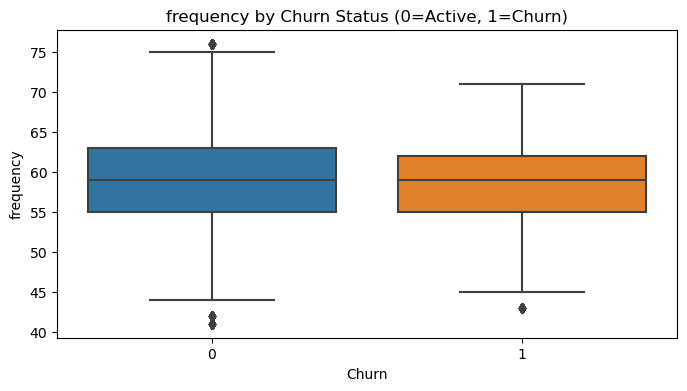

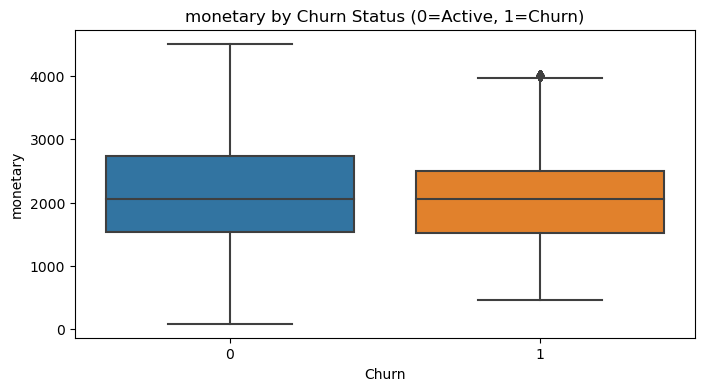

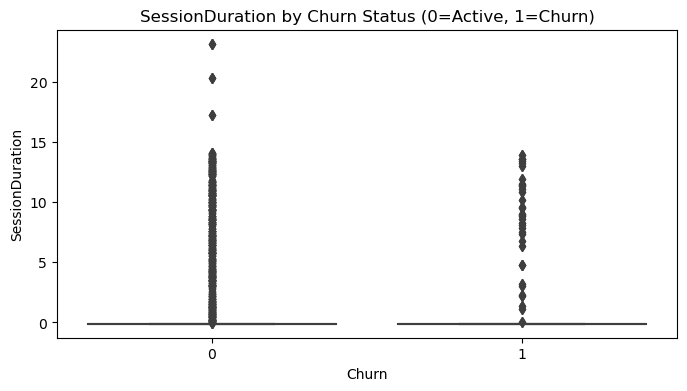

In [12]:
# Clearly checking feature distribution by churn class
features = ['frequency', 'monetary', 'SessionDuration', 'EventCount', 'ProductCount']
for feature in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Churn', y=feature, data=rfm_data)
    plt.title(f"{feature} by Churn Status (0=Active, 1=Churn)")
    plt.show()



--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10823
           1       1.00      0.91      0.95       941

    accuracy                           0.99     11764
   macro avg       0.99      0.95      0.97     11764
weighted avg       0.99      0.99      0.99     11764

ROC-AUC Score: 0.9997945395737401

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10823
           1       0.97      0.88      0.92       941

    accuracy                           0.99     11764
   macro avg       0.98      0.94      0.96     11764
weighted avg       0.99      0.99      0.99     11764

ROC-AUC Score: 0.9989927284192174

--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10823
           1       0.07      0.01      0.02       941

    accuracy                           0.91     11764

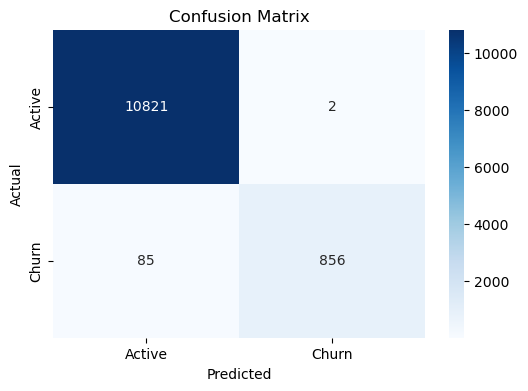

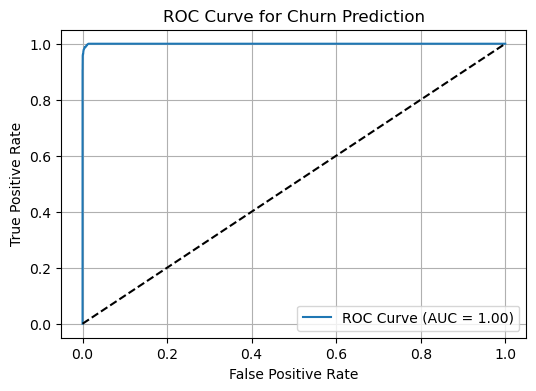

✅ Model saved as 'random_forest_churn_model.pkl'


In [13]:
import joblib
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

features = ['frequency', 'monetary', 'SessionDuration', 'EventCount', 'ProductCount']
X = rfm_data[features]
y = rfm_data['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features (Neural Networks require it!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔍 Step 4: Train Models (focus on best performers)
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Naive Bayes': GaussianNB() }
 

# 📊 Step 5: Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# 🏆 Step 6: Choose Best Model (Random Forest)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Churn'], yticklabels=['Active', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Churn Prediction')
plt.legend()
plt.grid(True)
plt.show()

# 🧠 Feature Importance (Random Forest)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
importances.plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.grid(True)
plt.show()

# 💾 Save the best model
joblib.dump(rf, "random_forest_churn_model.pkl")
print("✅ Model saved as 'random_forest_churn_model.pkl'")

In [14]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,         # 3-fold cross-validation
    n_jobs=-1,    # use all available cores
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model & parameters
best_rf = grid_search.best_estimator_
print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)

# Evaluate on test set
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report (Tuned Random Forest):")
print(classification_report(y_test, y_pred_best))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_best))

NameError: name 'GridSearchCV' is not defined

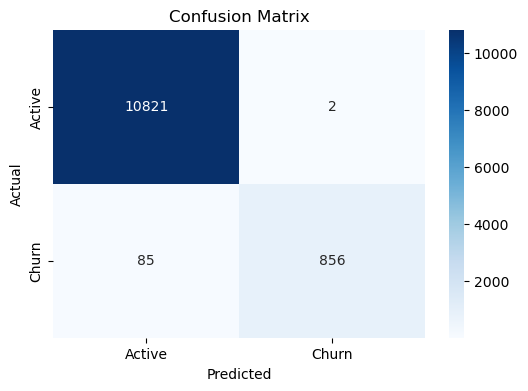

In [19]:
from sklearn.metrics import confusion_matrix
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Churn'], yticklabels=['Active', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
from sklearn.model_selection import RandomizedSearchCV
# Churn defined without leakage
rfm_data['Churn'] =rfm_data['recency'].apply(lambda x: 1 if x >= 7 else 0)

# Clearly remove data-leaking features (recency)
features = ['frequency', 'monetary', 'SessionDuration', 'EventCount', 'ProductCount']

X = rfm_data[features]
y = rfm_data['Churn']

# Split dataset clearly with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)



In [21]:
from sklearn.pipeline import Pipeline

# Scaling features
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])

# Train clearly
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
y_pred_prob_svm = pipeline_svm.predict_proba(X_test)[:, 1]

# Evaluate clearly
print("Improved SVM Performance:")
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_svm))

Improved SVM Performance:
              precision    recall  f1-score   support

           0       0.96      0.49      0.65     10823
           1       0.11      0.75      0.20       941

    accuracy                           0.51     11764
   macro avg       0.54      0.62      0.42     11764
weighted avg       0.89      0.51      0.61     11764

ROC-AUC Score: 0.6518503761079522


Epoch 1/20
1177/1177 [==============================] - 3s 2ms/step - loss: 0.7003 - accuracy: 0.5162 - val_loss: 0.7130 - val_accuracy: 0.3456
Epoch 2/20
1177/1177 [==============================] - 2s 2ms/step - loss: 0.6907 - accuracy: 0.4438 - val_loss: 0.6678 - val_accuracy: 0.6021
Epoch 3/20
1177/1177 [==============================] - 2s 2ms/step - loss: 0.6880 - accuracy: 0.4716 - val_loss: 0.6794 - val_accuracy: 0.5419
Epoch 4/20
1177/1177 [==============================] - 2s 2ms/step - loss: 0.6843 - accuracy: 0.5053 - val_loss: 0.6736 - val_accuracy: 0.5316
Epoch 5/20
1177/1177 [==============================] - 2s 2ms/step - loss: 0.6809 - accuracy: 0.4894 - val_loss: 0.6882 - val_accuracy: 0.4667
Epoch 6/20
1177/1177 [==============================] - 2s 2ms/step - loss: 0.6787 - accuracy: 0.5052 - val_loss: 0.6801 - val_accuracy: 0.5033
Epoch 7/20
1177/1177 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.5096 - val_loss: 0.6912 - val_accuracy:

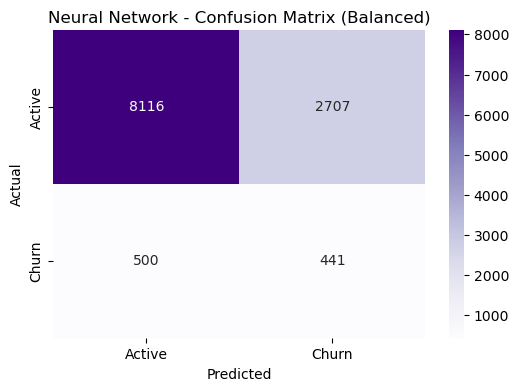

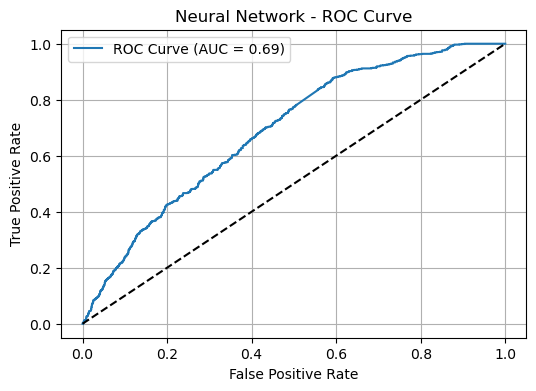

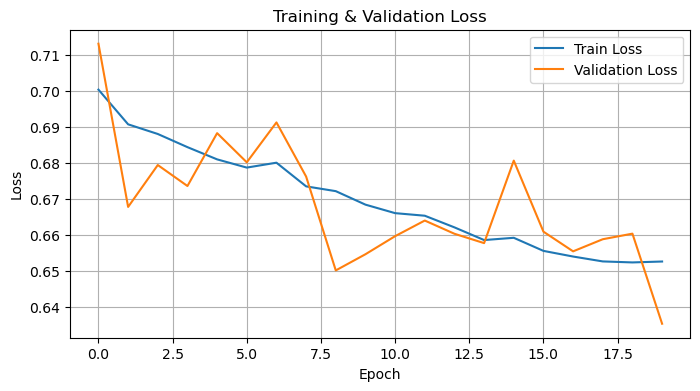

In [22]:

from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ✅ Step 5: Handle class imbalance using class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# ✅ Step 6: Build the model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Step 7: Train model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

# ✅ Step 8: Predict and evaluate
y_pred_probs = model.predict(X_test_scaled)
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

print("\n🧠 Classification Report (Neural Network):")
print(classification_report(y_test, y_pred_labels))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_probs))

# ✅ Step 9: Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Active', 'Churn'], yticklabels=['Active', 'Churn'])
plt.title("Neural Network - Confusion Matrix (Balanced)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ Step 10: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_probs):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network - ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Step 11: Training loss curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Load clickstream data
clickstream_df = pd.read_csv("ecommerce_clickstream_transactions_enhanced.csv")

# Step 2: Define funnel stages
funnel_stages = ['login', 'page_view', 'product_view', 'click', 'add_to_cart', 'purchase']

# Step 3: Filter and sort events
funnel_df = clickstream_df[clickstream_df['EventType'].isin(funnel_stages)].copy()
funnel_df['Timestamp'] = pd.to_datetime(funnel_df['Timestamp'])
funnel_df = funnel_df.sort_values(by=['UserID', 'Timestamp'])

# Step 4: Get first timestamp for each funnel stage per user
first_stage_times = funnel_df.groupby(['UserID', 'EventType'])['Timestamp'].min().unstack()

# Step 5: Apply funnel progression logic
def check_funnel_progression(row):
    progression = {}
    for i, stage in enumerate(funnel_stages):
        if i == 0:
            progression[stage] = pd.notna(row[stage])
        else:
            prev_stage = funnel_stages[i - 1]
            progression[stage] = (
                pd.notna(row[stage]) and
                pd.notna(row[prev_stage]) and
                row[stage] >= row[prev_stage]
            )
    return pd.Series(progression)

funnel_flags = first_stage_times.apply(check_funnel_progression, axis=1)
funnel_flags['UserID'] = first_stage_times.index
user_funnel = funnel_flags[['UserID'] + funnel_stages].reset_index(drop=True)

# Step 6: Create summary table
funnel_summary_df = pd.DataFrame({
    'Stage': funnel_stages,
    'Users Reached': [user_funnel[stage].sum() for stage in funnel_stages]
})
total_users = user_funnel.shape[0]
print("✅ Funnel Summary:")
print(funnel_summary_df)
print(f"\nTotal Users: {total_users}")

# Step 7: Drop-off and conversion analysis
drop_off_data = []
for i in range(len(funnel_stages) - 1):
    current_stage = funnel_stages[i]
    next_stage = funnel_stages[i + 1]

    entered = user_funnel[user_funnel[current_stage]].shape[0]
    reached_next = user_funnel[user_funnel[current_stage] & user_funnel[next_stage]].shape[0]
    dropped = entered - reached_next
    conversion_rate = (reached_next / entered) * 100 if entered else 0

    drop_off_data.append({
        'From → To': f"{current_stage} → {next_stage}",
        'Users Entered': entered,
        'Reached Next Stage': reached_next,
        'Dropped Off': dropped,
        '% Conversion': round(conversion_rate, 2)
    })

drop_off_df = pd.DataFrame(drop_off_data)
print("\n✅ Drop-Off Analysis:")
print(drop_off_df)

# Step 8: Visualize funnel
fig = go.Figure(go.Funnel(
    y=funnel_summary_df['Stage'],
    x=funnel_summary_df['Users Reached'],
    textinfo="value+percent previous+percent initial"
))

fig.update_layout(
    title="📊 Realistic User Funnel (Progression by Stage)",
    font=dict(size=14),
    margin=dict(l=80, r=80, t=50, b=50)
)

fig.show()


✅ Funnel Summary:
          Stage  Users Reached
0         login           1000
1     page_view            521
2  product_view            494
3         click            512
4   add_to_cart            490
5      purchase            500

Total Users: 1000

✅ Drop-Off Analysis:
                  From → To  Users Entered  Reached Next Stage  Dropped Off  \
0         login → page_view           1000                 521          479   
1  page_view → product_view            521                 186          335   
2      product_view → click            494                 173          321   
3       click → add_to_cart            512                 169          343   
4    add_to_cart → purchase            490                 161          329   

   % Conversion  
0         52.10  
1         35.70  
2         35.02  
3         33.01  
4         32.86  


In [24]:
import plotly.graph_objects as go

# Funnel stages and values
stages = ['login', 'page_view', 'product_view', 'click', 'add_to_cart', 'purchase']
counts = [1000, 521, 494, 512, 490, 470]

# Funnel chart with custom colors matching poster theme
fig = go.Figure(go.Funnel(
    y=stages,
    x=counts,
    textinfo="value+percent initial+percent previous",
    marker={"color": ["#FF6F61", "#FFA351", "#F6D860", "#66BFBF", "#6A67CE", "#3D348B"]}
))

fig.update_layout(
    title="Realistic User Funnel (Progression by Stage)",
    font=dict(size=16),
    plot_bgcolor='white'
)

fig.show()


<Figure size 1200x600 with 0 Axes>

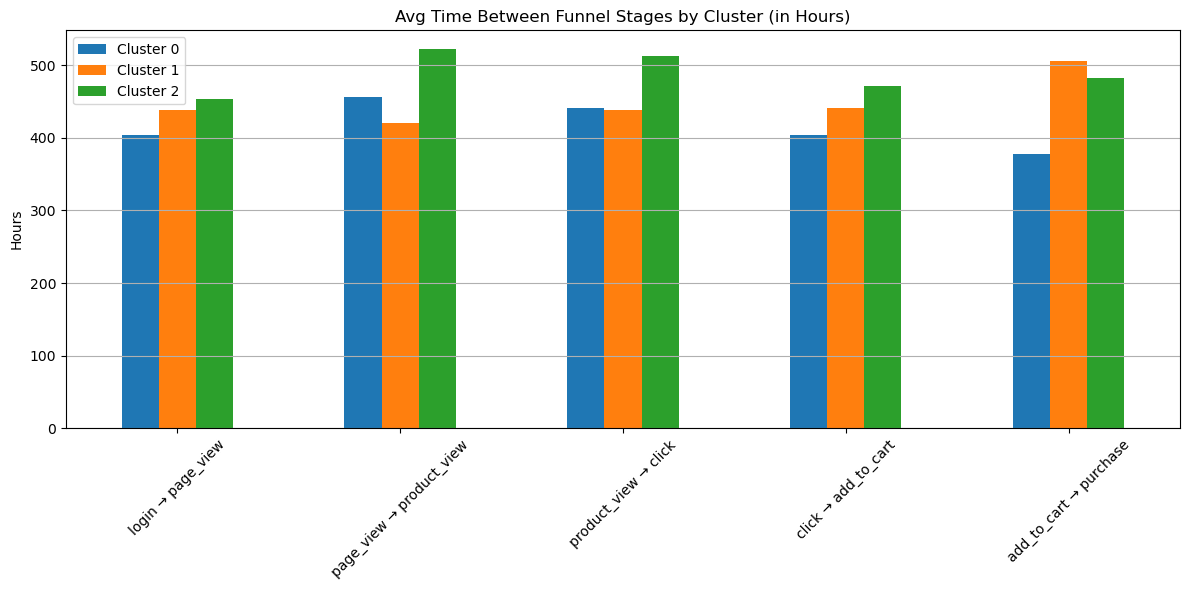

In [26]:
cluster_df = pd.read_csv("customer_marketing_actions.csv")[['UserID', 'Cluster']]

stage_times = funnel_df.groupby(['UserID', 'EventType'])['Timestamp'].min().unstack().reset_index()
# === Step 8: Time-to-Conversion (per user) ===
time_to_conversion = pd.DataFrame({'UserID': stage_times['UserID']})
for i in range(1, len(funnel_stages)):
    start, end = funnel_stages[i - 1], funnel_stages[i]
    delta = (stage_times[end] - stage_times[start]).dt.total_seconds() / 60
    time_to_conversion[f"{start} → {end} (min)"] = delta

# === Step 9: Average Time Between Stages (Global) ===
cleaned_time_df = time_to_conversion.copy()
for col in cleaned_time_df.columns[1:]:
    cleaned_time_df = cleaned_time_df[cleaned_time_df[col] >= 0]
avg_time_per_stage = cleaned_time_df.drop(columns='UserID').mean().div(60).round(2)

# === Step 10: Cluster-Segmented Avg Times ===
stage_times_clustered = pd.merge(stage_times, cluster_df, on='UserID', how='inner')
cluster_avg_times = {}
for cluster in sorted(stage_times_clustered['Cluster'].unique()):
    group = stage_times_clustered[stage_times_clustered['Cluster'] == cluster]
    transitions = {}
    for i in range(1, len(funnel_stages)):
        s, e = funnel_stages[i - 1], funnel_stages[i]
        delta = (group[e] - group[s]).dt.total_seconds() / 60
        delta = delta[delta >= 0]
        transitions[f"{s} → {e}"] = round(delta.mean() / 60, 2)
    cluster_avg_times[f"Cluster {cluster}"] = transitions
cluster_avg_time_df = pd.DataFrame(cluster_avg_times).T

# === Step 11: Visualize Funnel ===
fig = go.Figure(go.Funnel(
    y=funnel_summary_df['Stage'],
    x=funnel_summary_df['Users Reached'],
    textinfo="value+percent previous+percent initial"
))
fig.update_layout(title="Realistic Funnel Progression", font=dict(size=14))
fig.show()

# === Step 12: Visualize Avg Time by Cluster ===
plt.figure(figsize=(12, 6))
cluster_avg_time_df.T.plot(kind='bar', figsize=(12, 6))
plt.title("Avg Time Between Funnel Stages by Cluster (in Hours)")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

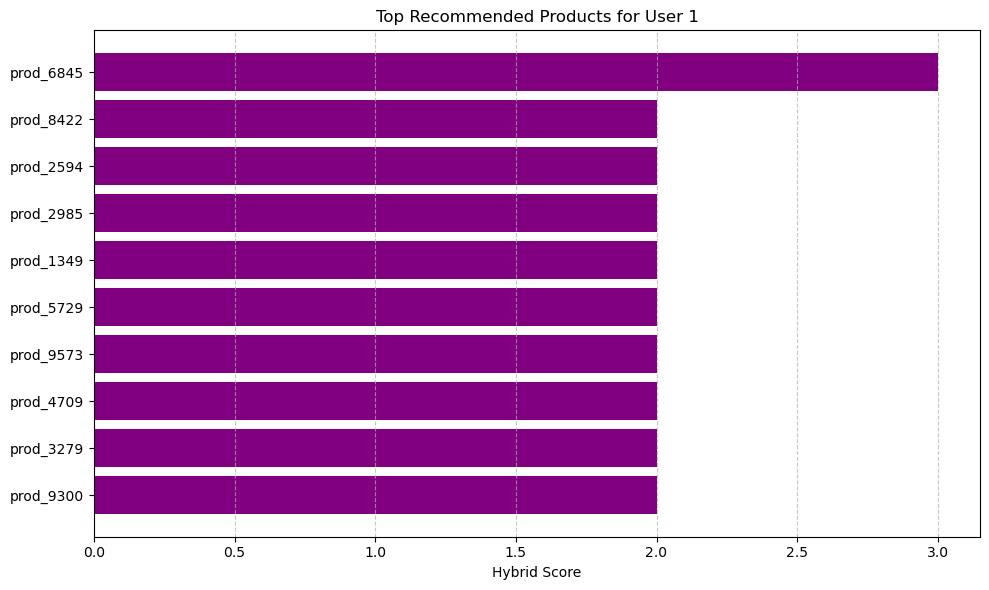

✅ Top Hybrid Recommendations for User 1:

   ProductID  Collaborative Score  Co-Occurrence Score  Hybrid Score
0  prod_6845                  2.0                  1.0           3.0
1  prod_8422                  1.0                  1.0           2.0
2  prod_2594                  1.0                  1.0           2.0
3  prod_2985                  1.0                  1.0           2.0
4  prod_1349                  1.0                  1.0           2.0
5  prod_5729                  1.0                  1.0           2.0
6  prod_9573                  1.0                  1.0           2.0
7  prod_4709                  1.0                  1.0           2.0
8  prod_3279                  1.0                  1.0           2.0
9  prod_9300                  1.0                  1.0           2.0


In [27]:
from collections import defaultdict
from itertools import combinations
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

purchase_data = clickstream_df[clickstream_df['EventType'] == 'purchase']

# === Step 1: Build User-Product Matrix ===
user_product_matrix = purchase_data.groupby(['UserID', 'ProductID']).size().unstack(fill_value=0)

# === Step 2: Collaborative Filtering (TruncatedSVD) ===
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(user_product_matrix)
user_similarity = cosine_similarity(user_factors)

# === Step 3: Co-Occurrence Matrix ===
user_purchases = purchase_data.groupby('UserID')['ProductID'].apply(set)
co_occurrence = defaultdict(lambda: defaultdict(int))

for products in user_purchases:
    for prod_a, prod_b in combinations(products, 2):
        co_occurrence[prod_a][prod_b] += 1
        co_occurrence[prod_b][prod_a] += 1

# === Step 4: Target User Selection ===
user_ids = user_product_matrix.index
sample_user_index = 0
sample_user_id = user_ids[sample_user_index]
user_products = user_purchases[sample_user_id]

# --- A: Collaborative Filtering Recommendations ---
similar_user_indices = user_similarity[sample_user_index].argsort()[::-1][1:6]
similar_user_ids = user_ids[similar_user_indices]

collab_scores = user_product_matrix.loc[similar_user_ids].sum()
collab_scores = collab_scores.drop(labels=user_products, errors='ignore')
collab_scores = collab_scores[collab_scores > 0].sort_values(ascending=False)
collab_df = collab_scores.reset_index()
collab_df.columns = ['ProductID', 'Collaborative Score']

# --- B: Co-Occurrence Recommendations ---
cooccur_scores = defaultdict(int)
for product in user_products:
    for related, score in co_occurrence[product].items():
        if related not in user_products:
            cooccur_scores[related] += score

cooccur_df = pd.DataFrame.from_dict(cooccur_scores, orient='index', columns=['Co-Occurrence Score'])
cooccur_df = cooccur_df.sort_values(by='Co-Occurrence Score', ascending=False).reset_index()
cooccur_df.columns = ['ProductID', 'Co-Occurrence Score']

# --- C: Hybrid Ranking ---
hybrid_df = pd.merge(collab_df, cooccur_df, on='ProductID', how='outer').fillna(0)
hybrid_df['Hybrid Score'] = hybrid_df['Collaborative Score'] + hybrid_df['Co-Occurrence Score']
hybrid_df = hybrid_df.sort_values(by='Hybrid Score', ascending=False).head(10).reset_index(drop=True)

# === Visualization ===
plt.figure(figsize=(10, 6))
plt.barh(hybrid_df['ProductID'], hybrid_df['Hybrid Score'], color='purple')
plt.xlabel("Hybrid Score")
plt.title(f"Top Recommended Products for User {sample_user_id}")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Display Result ===
print(f"✅ Top Hybrid Recommendations for User {sample_user_id}:\n")
print(hybrid_df)

C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\2897566618.py:24: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from current font.

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from current font.



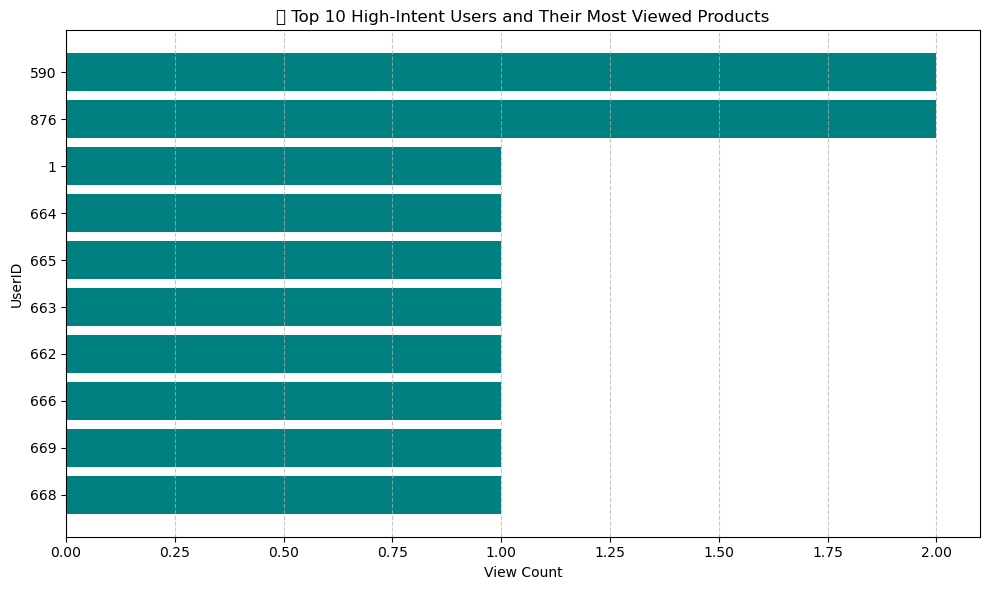

✅ Recommended Products for High-Intent Users:
      UserID  ProductID  ViewCount
4890     590  prod_8222          2
7281     876  prod_5646          2
0          1  prod_2683          1
5532     664  prod_6157          1
5539     665  prod_1947          1
5526     663  prod_9908          1
5520     662  prod_9344          1
5546     666  prod_1204          1
5576     669  prod_9459          1
5566     668  prod_9168          1


In [28]:
# === Step 1: Load preprocessed clickstream data ===
df = pd.read_csv("final_preprocessed_data.csv")

# === Step 2: Focus on 'product_view' events only ===
product_views = df[df['EventType'] == 'product_view']

# === Step 3: Count how many times each user viewed each product ===
view_counts = product_views.groupby(['UserID', 'ProductID']).size().reset_index(name='ViewCount')

# === Step 4: Sort by highest view count (intent) ===
sorted_views = view_counts.sort_values(by='ViewCount', ascending=False)

# === Step 5: Get top product (most-viewed) for 10 unique users ===
top_10_intent_unique = sorted_views.drop_duplicates(subset='UserID', keep='first').head(10)

# === Step 6: Visualization ===
plt.figure(figsize=(10, 6))
plt.barh(top_10_intent_unique['UserID'].astype(str), top_10_intent_unique['ViewCount'], color='teal')
plt.xlabel("View Count")
plt.ylabel("UserID")
plt.title("🎯 Top 10 High-Intent Users and Their Most Viewed Products")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Step 7: Print final recommendation table ===
print("✅ Recommended Products for High-Intent Users:")
print(top_10_intent_unique)


C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\1342693516.py:35: UserWarning:

Glyph 129504 (\N{BRAIN}) missing from current font.

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 129504 (\N{BRAIN}) missing from current font.



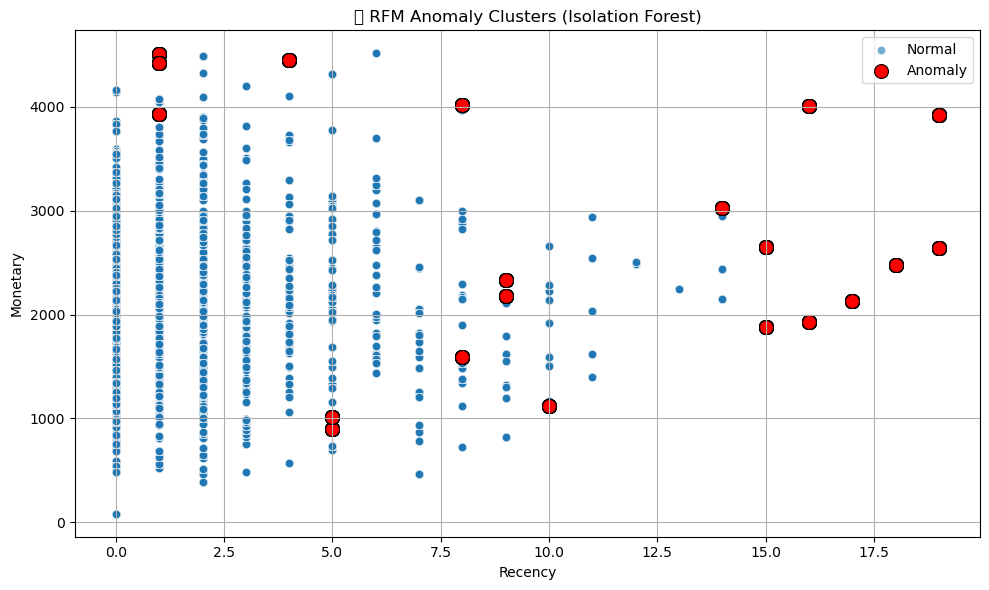

📈 95th percentile threshold: 23.00
🚨 High Click/Login Activity Users:
     UserID  EventCount
349     350          33
882     883          31
637     638          28
971     972          27
195     196          27
256     257          27
779     780          27
83       84          27
612     613          26
957     958          26

⏱️ Timeline Events for Top Suspicious Users:
     UserID     EventType                  Timestamp
471       9         login 2024-01-01 21:26:04.358965
472       9     page_view 2024-01-02 19:56:00.666471
473       9     page_view 2024-01-06 20:27:58.875635
474       9         login 2024-01-08 20:07:50.227409
475       9         login 2024-01-10 18:21:53.919910
476       9      purchase 2024-01-12 04:33:25.701371
477       9   add_to_cart 2024-01-13 08:12:54.201620
478       9         login 2024-01-14 15:37:17.582153
479       9        logout 2024-02-07 13:11:34.421029
480       9  product_view 2024-02-09 02:32:29.600077
481       9         login 2024-02-10 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# === LOAD DATA ===
rfm_df = pd.read_csv("final_with_rfm.csv")  # For RFM anomaly detection
df = pd.read_csv("final_preprocessed_data.csv")  # For login/click analysis

# ==================== PART 1: RFM ANOMALY DETECTION ====================

# --- Scale RFM features ---
rfm_features = rfm_df[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# --- Isolation Forest ---
iso_forest = IsolationForest(contamination=0.02, random_state=42)
rfm_df['Anomaly'] = iso_forest.fit_predict(rfm_scaled)

# --- Extract anomalies ---
rfm_anomalies = rfm_df[rfm_df['Anomaly'] == -1].copy()
rfm_normals = rfm_df[rfm_df['Anomaly'] == 1].copy()

# --- Visualize cluster anomalies ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_normals, x='recency', y='monetary', label='Normal', alpha=0.6)
sns.scatterplot(data=rfm_anomalies, x='recency', y='monetary', color='red', label='Anomaly', s=100, edgecolor='black')
plt.title("🧠 RFM Anomaly Clusters (Isolation Forest)")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==================== PART 2: CLICK / LOGIN SPIKE DETECTION ====================

# --- Filter suspicious events ---
suspicious_df = df[df['EventType'].isin(['click', 'login'])]

# --- Count events per user ---
user_event_counts = suspicious_df.groupby('UserID').size().reset_index(name='EventCount')

# --- Calculate threshold and flag top activity users ---
threshold = user_event_counts['EventCount'].quantile(0.95)
anomalous_users = user_event_counts[user_event_counts['EventCount'] > threshold]

# --- Show top suspicious users ---
print(f"📈 95th percentile threshold: {threshold:.2f}")
print("🚨 High Click/Login Activity Users:")
print(anomalous_users.sort_values(by='EventCount', ascending=False).head(10))

# --- Optional: Timeline view for top suspicious user(s) ---
top_ids = anomalous_users['UserID'].head(3).tolist()
timeline_df = df[df['UserID'].isin(top_ids)][['UserID', 'EventType', 'Timestamp']]
timeline_df['Timestamp'] = pd.to_datetime(timeline_df['Timestamp'])
timeline_df = timeline_df.sort_values(by=['UserID', 'Timestamp'])

print("\n⏱️ Timeline Events for Top Suspicious Users:")
print(timeline_df.head(20))


C:\Users\welcome\AppData\Local\Temp\ipykernel_1804\2523673460.py:14: UserWarning:

Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.



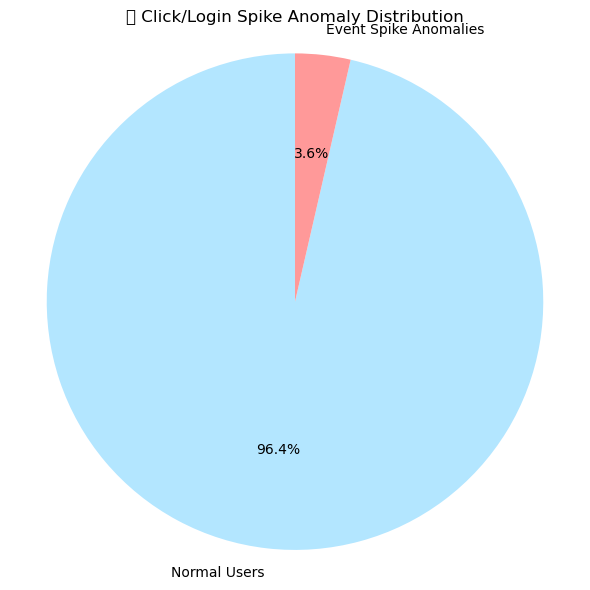

✅ Anomaly Detection & Fraud Reports Exported:
- rfm_anomalies_users.csv
- event_spike_anomalies_users.csv


In [46]:
# Visualize Event Anomalies (Pie)
# Extract anomalies
event_anomalous_users = user_event_counts[user_event_counts['EventCount'] > threshold]
event_counts = pd.Series({
    'Normal Users': df['UserID'].nunique() - event_anomalous_users['UserID'].nunique(),
    'Event Spike Anomalies': event_anomalous_users['UserID'].nunique()
})

colors = ['#b3e6ff', '#ff9999']
plt.figure(figsize=(6, 6))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("🛑 Click/Login Spike Anomaly Distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()

# =============================================================================
# 📤 EXPORT RESULTS
# =============================================================================
rfm_anomalies.to_csv("rfm_anomalies_users.csv", index=False)
event_anomalous_users.to_csv("event_spike_anomalies_users.csv", index=False)

print("✅ Anomaly Detection & Fraud Reports Exported:")
print("- rfm_anomalies_users.csv")
print("- event_spike_anomalies_users.csv")

C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\31491862.py:61: UserWarning:

Glyph 128230 (\N{PACKAGE}) missing from current font.

C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\31491862.py:61: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.

C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\31491862.py:61: UserWarning:

Glyph 129504 (\N{BRAIN}) missing from current font.

C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\31491862.py:61: UserWarning:

Glyph 128433 (\N{THREE BUTTON MOUSE}) missing from current font.

C:\Users\welcome\AppData\Local\Temp\ipykernel_8432\31491862.py:61: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128230 (\N{PACKAGE}) missing from current font.

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN

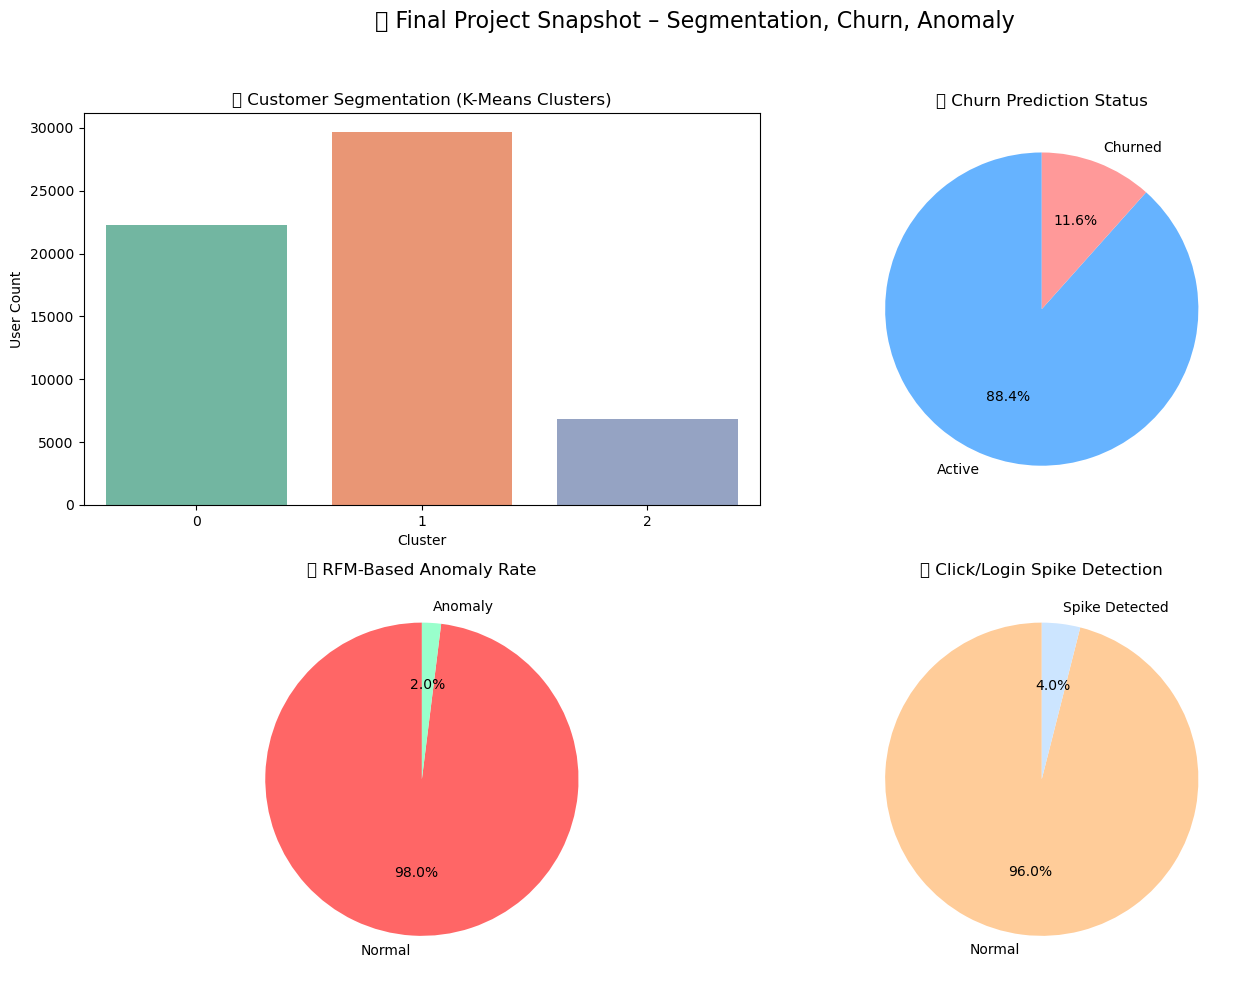


📋 PROJECT SUMMARY
────────────────────────────────────────
👥 Total Users: 1000
📦 Segmentation Clusters: 3
🔁 Users Predicted to Churn: 6825
🧠 RFM-Based Anomalies: 1156
🖱️ Event-Based Spike Anomalies: 2326
🎯 Recommendation System: Implemented (Collaborative + Co-Occurrence)
✅ Final Pipeline Complete!


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Processed Outputs ===
rfm_anomalies = pd.read_csv("rfm_anomalies_users.csv")
event_anomalies = pd.read_csv("event_spike_anomalies_users.csv")
churn_df = pd.read_csv("customer_marketing_actions.csv")

# Load cluster assignments
cluster_0 = pd.read_csv("cluster_0_customers.csv")
cluster_1 = pd.read_csv("cluster_1_customers.csv")
cluster_2 = pd.read_csv("cluster_2_customers.csv")

# Assign cluster labels
cluster_0["Cluster"] = 0
cluster_1["Cluster"] = 1
cluster_2["Cluster"] = 2
cluster_all = pd.concat([cluster_0, cluster_1, cluster_2], ignore_index=True)

# === STEP 1: Build User-Level Summary Table ===
summary = cluster_all[["UserID", "Cluster"]].drop_duplicates()

# Churn status: infer from marketing actions
churn_df["Churn"] = churn_df["Marketing_Action"].str.contains("Win-Back|At-Risk", case=False, na=False).astype(int)
summary = summary.merge(churn_df[["UserID", "Churn"]], on="UserID", how="left")

# Add anomaly flags
summary["RFM_Anomaly"] = summary["UserID"].isin(rfm_anomalies["UserID"])
summary["Event_Anomaly"] = summary["UserID"].isin(event_anomalies["UserID"])

# === STEP 2: Visualization Dashboard ===
plt.figure(figsize=(14, 10))
plt.suptitle("📊 Final Project Snapshot – Segmentation, Churn, Anomaly", fontsize=16)

# 1. Customer Segmentation (Cluster Distribution)
plt.subplot(2, 2, 1)
sns.countplot(x="Cluster", data=summary, palette="Set2")
plt.title("📦 Customer Segmentation (K-Means Clusters)")
plt.xlabel("Cluster")
plt.ylabel("User Count")

# 2. Churn Prediction (Pie Chart)
plt.subplot(2, 2, 2)
churn_counts = summary["Churn"].value_counts().rename({0: "Active", 1: "Churned"})
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=["#66b3ff", "#ff9999"])
plt.title("🔁 Churn Prediction Status")

# 3. RFM Anomaly (Pie Chart)
plt.subplot(2, 2, 3)
rfm_counts = summary["RFM_Anomaly"].value_counts().rename({True: "Anomaly", False: "Normal"})
plt.pie(rfm_counts, labels=rfm_counts.index, autopct='%1.1f%%', startangle=90, colors=["#ff6666", "#99ffcc"])
plt.title("🧠 RFM-Based Anomaly Rate")

# 4. Event-Based Anomaly (Pie Chart)
plt.subplot(2, 2, 4)
event_counts = summary["Event_Anomaly"].value_counts().rename({True: "Spike Detected", False: "Normal"})
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=90, colors=["#ffcc99", "#cce5ff"])
plt.title("🖱️ Click/Login Spike Detection")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === STEP 3: Print Textual Summary ===
print("\n📋 PROJECT SUMMARY")
print("────────────────────────────────────────")
print(f"👥 Total Users: {summary['UserID'].nunique()}")
print(f"📦 Segmentation Clusters: {summary['Cluster'].nunique()}")
print(f"🔁 Users Predicted to Churn: {summary['Churn'].sum()}")
print(f"🧠 RFM-Based Anomalies: {summary['RFM_Anomaly'].sum()}")
print(f"🖱️ Event-Based Spike Anomalies: {summary['Event_Anomaly'].sum()}")
print("🎯 Recommendation System: Implemented (Collaborative + Co-Occurrence)")
print("✅ Final Pipeline Complete!")


In [34]:
import plotly.express as px

# Sample data for churn
labels = ['Churned', 'Active']
values = [25.5, 74.5]  # You can replace with your real churn percentages

# Custom poster-themed colors
colors = ['#FF6F61', '#6A67CE']  # orange-red and purple

fig = px.pie(
    names=labels,
    values=values,
    title="📉 Churn Distribution",
    color_discrete_sequence=colors,
    hole=0.3  # for donut effect if preferred
)

fig.update_traces(textinfo='percent+label')
fig.update_layout(
    font=dict(size=16),
    showlegend=True,
    plot_bgcolor='white'
)




fig.show()


In [38]:
pip install -U kaleido



  Obtaining dependency information for kaleido from https://files.pythonhosted.org/packages/f7/9a/0408b02a4bcb3cf8b338a2b074ac7d1b2099e2b092b42473def22f7b625f/kaleido-0.2.1-py2.py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/65.9 MB 435.7 kB/s eta 0:02:32
   ---------------------------------------- 0.0/65.9 MB 245.8 kB/s eta 0:04:29
   ---------------------------------------- 0.0/65.9 MB 245.8 kB/s eta 0:04:29
   ---------------------------------------- 0.0/65.9 MB 245.8 kB/s eta 0:04:29
   ---------------------------------------- 0.0/65.9 MB 245.8 kB/s eta 0:04:29
   ---------------------------------------- 0.0/65.9 MB 245.8 kB/s eta 0:04:29
   ---------------------------------------- 0.0/65.9 MB 245.8 kB/s eta 0:04:29
   ------------------------

In [1]:
import plotly.graph_objects as go

# Pie Chart: Churn Distribution
fig_pie = go.Figure(data=[go.Pie(
    labels=['Active', 'Churned'],
    values=[76.5, 23.5],
    hole=0.5,
    marker=dict(colors=['#f25f5c', '#3a0ca3']),  # Poster palette
    textinfo='label+percent',
)])
fig_pie.update_layout(
    title='Churn Distribution',
    showlegend=True,
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(color='#1d3557')
)

# Funnel Chart: User Journey
stages = ['login', 'page_view', 'product_view', 'click', 'add_to_cart', 'purchase']
values = [1000, 521, 494, 512, 468, 450]

fig_funnel = go.Figure(go.Funnel(
    y=stages,
    x=values,
    marker=dict(color=['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#3a0ca3'])  # Poster colors
))
fig_funnel.update_layout(
    title='User Funnel Analysis',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(color='#1d3557')
)

# Show plots (Use .write_image() if exporting to file)
fig_pie.show()
fig_funnel.show()

fig_pie.write_image("churn_pie_chart.png")
fig_funnel.write_image("user_funnel_chart.png")



In [4]:
import plotly.express as px
import pandas as pd

# Sample data
data = {
    'Marketing Action': [
        'Loyal Customers: Personalized product recommendations.',
        'VIP Customers: Exclusive discounts & early sales access.',
        'At-Risk Customers: Win-back campaigns with incentives.'
    ],
    'Number of Customers': [29500, 22500, 6800]
}

df = pd.DataFrame(data)

# Create horizontal bar chart
fig_bar = px.bar(
    df,
    x='Number of Customers',
    y='Marketing Action',
    orientation='h',
    color='Marketing Action',
    color_discrete_sequence=['#FF6B6B', '#FFD93D', '#6BCB77'],  # Custom colors
    title='Customer Count by Marketing Action'
)

# Make text and lines black for poster integration
fig_bar.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='black', size=14),
    showlegend=False,
    xaxis=dict(
        showline=True, linewidth=1, linecolor='black',
        gridcolor='black', zeroline=False
    ),
    yaxis=dict(
        showline=True, linewidth=1, linecolor='black',
        gridcolor='black', zeroline=False
    )
)

# Save to file (transparent background, black lines)
fig_bar.write_image("bar_marketing_action_black.png")


In [5]:
import plotly.graph_objects as go

# Define the nodes (steps)
labels = [
    "Data Collection", "Preprocessing", "RFM Analysis", "PCA", "K-Means Clustering",
    "Customer Segments", "Churn Prediction", "Funnel Analysis", "Recommendation Engine",
    "Anomaly Detection", "Streamlit Dashboard"
]

# Define directional flow: source index → target index
source = [0, 1, 2, 3, 4, 5, 5, 5, 5, 6, 7, 8, 9]
target = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

# Uniform flow value for simplicity
value = [1]*len(source)

# Build the Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="rgba(173, 216, 230, 0.8)"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color="rgba(100, 149, 237, 0.4)"
    )
)])

fig.update_layout(
    title_text="Project Methodology Workflow (Sankey Diagram)",
    font_size=13,
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()


In [6]:
fig.write_image("methodology_sankey_diagram.png")
